In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = torch.softmax(self.output_layer(x), dim=-1)
        return x

# Define the value network
class ValueNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(ValueNetwork, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        value = self.output_layer(x)
        return value

# Function to select an action based on the policy network
def select_action(policy_net, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy_net(state)  # Get action probabilities from the policy network
    action = torch.multinomial(probs, num_samples=1).item()  # Sample from the action distribution
    return action, torch.log(probs[0, action])

# Function to compute returns
def compute_returns(rewards, gamma=0.99):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

# Train the policy using REINFORCE with baseline
def reinforce_with_baseline(env, policy_net, value_net, policy_optimizer, value_optimizer, num_episodes=500, gamma=0.99):
    total_rewards = []  # List to store total rewards per episode

    for episode in range(num_episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        values = []
        
        # Collect trajectory for one episode
        done = False
        while not done:
            action, log_prob = select_action(policy_net, state)
            value = value_net(torch.from_numpy(state).float().unsqueeze(0))
            
            next_state, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            log_probs.append(log_prob)
            rewards.append(reward)
            values.append(value)
            
            state = next_state
        
        # Compute returns
        returns = compute_returns(rewards, gamma)
        returns = torch.tensor(returns)
        values = torch.cat(values).squeeze()
        
        # Calculate advantages
        advantages = returns - values.detach()
        
        # Policy loss (using the advantage as the weight)
        policy_loss = [-log_prob * advantage for log_prob, advantage in zip(log_probs, advantages)]
        policy_loss = torch.stack(policy_loss).sum()

        # Value loss (MSE between returns and predicted values)
        value_loss = nn.functional.mse_loss(values, returns)
        
        # Update the policy network (actor)
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()
        
        # Update the value network (critic)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        # Store total reward for the episode
        total_rewards.append(sum(rewards))

        # Print progress
        if episode % 50 == 0:
            print(f"Episode {episode}, Total Reward: {sum(rewards)}")

    return total_rewards  # Return the rewards for plotting

In [6]:
# Create the environment
env = gym.make("CartPole-v1")
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

# Initialize policy and value networks
policy_net = PolicyNetwork(input_dim, output_dim)
value_net = ValueNetwork(input_dim)

# Optimizers for policy and value networks
policy_optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
value_optimizer = optim.Adam(value_net.parameters(), lr=1e-3)

# Train the policy using REINFORCE with Baseline
total_rewards = reinforce_with_baseline(env, policy_net, value_net, policy_optimizer, value_optimizer, num_episodes=600)

# Close the environment
env.close()

Episode 0, Total Reward: 56.0
Episode 50, Total Reward: 27.0
Episode 100, Total Reward: 56.0
Episode 150, Total Reward: 132.0
Episode 200, Total Reward: 26.0
Episode 250, Total Reward: 353.0
Episode 300, Total Reward: 224.0
Episode 350, Total Reward: 496.0
Episode 400, Total Reward: 500.0
Episode 450, Total Reward: 324.0
Episode 500, Total Reward: 500.0
Episode 550, Total Reward: 358.0


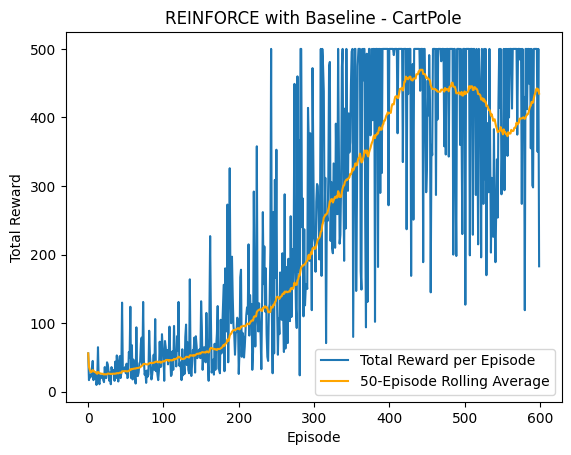

In [7]:
# Calculate the recent 50-episode interval average
window_size = 50
rolling_avg = [np.mean(total_rewards[max(0, i-window_size):(i+1)]) for i in range(len(total_rewards))]

# Plot the total rewards and rolling average over episodes
plt.plot(total_rewards, label='Total Reward per Episode')
plt.plot(rolling_avg, label=f'{window_size}-Episode Rolling Average', color='orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('REINFORCE with Baseline - CartPole')
plt.legend()
plt.show()
